# Wind Speed

## Import Libraries

In [88]:
pip install keras-tcn

Note: you may need to restart the kernel to use updated packages.


In [89]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tcn import TCN
from keras.models import Sequential
from keras.layers import LSTM, GRU, Dense, Dropout, concatenate

import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from pylab import rcParams
import statsmodels.api as sm
import plotly.express as px
import os
import csv

from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
# from keras.preprocessing.sequence import TimeseriesGenerator

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
# from keras.preprocessing.sequence import TimeseriesGenerator

import tensorflow as tf
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Flatten, LSTM, Dropout, SimpleRNN
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import RepeatVector, TimeDistributed, Input, BatchNormalization, multiply, concatenate, Activation, dot
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop,Adam,SGD,Adagrad, Nadam, Ftrl
from tensorflow.keras.utils import plot_model
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import keras.backend as K
import datetime
from tensorflow.keras import regularizers
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
tf.keras.utils.set_random_seed(48)
tf.config.experimental.enable_op_determinism()

## Read CSV

In [90]:
df = pd.read_csv('D:\C_downl\drive-download-20240928T074710Z-001\Data\san francisco.csv',index_col='Date/Time', parse_dates=True)

In [91]:
dataset = 'san_francisco'
savefilename = 'san_francisco.csv'

In [92]:
df = df[df.index.minute == 0]

In [93]:
df = pd.DataFrame({'120m' : df['120m']}, index=df.index)

In [94]:
display(df)

120m
Date/Time                 
2020-01-01 00:00:00   0.84
2020-01-01 01:00:00   2.66
2020-01-01 02:00:00   3.96
2020-01-01 03:00:00   4.02
2020-01-01 04:00:00   2.77
...                    ...
2022-12-31 19:00:00  12.93
2022-12-31 20:00:00  12.24
2022-12-31 21:00:00  10.32
2022-12-31 22:00:00   6.27
2022-12-31 23:00:00   4.33

[26304 rows x 1 columns]

In [95]:
df.head(5)

120m
Date/Time                
2020-01-01 00:00:00  0.84
2020-01-01 01:00:00  2.66
2020-01-01 02:00:00  3.96
2020-01-01 03:00:00  4.02
2020-01-01 04:00:00  2.77

In [96]:
df.describe()

120m
count  26304.000000
mean       6.091799
std        3.380642
min        0.020000
25%        3.420000
50%        5.850000
75%        8.440000
max       22.490000

In [97]:
df.isna().sum()

120m    0
dtype: int64

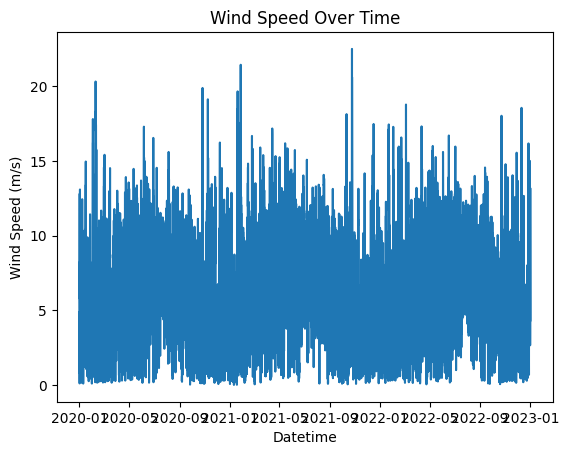

In [98]:
plt.plot(df)
plt.title('Wind Speed Over Time')
plt.xlabel('Datetime')
plt.ylabel('Wind Speed (m/s)')
plt.savefig('jaisalmer.png')
plt.show()

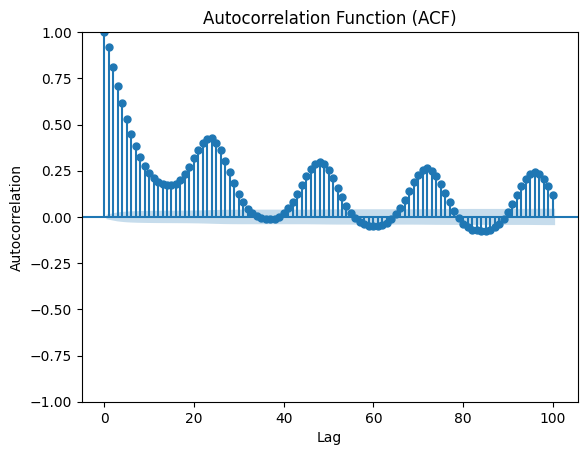

In [99]:
plot_acf(df, lags=100)  # You can adjust the number of lags as needed
plt.title('Autocorrelation Function (ACF)')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

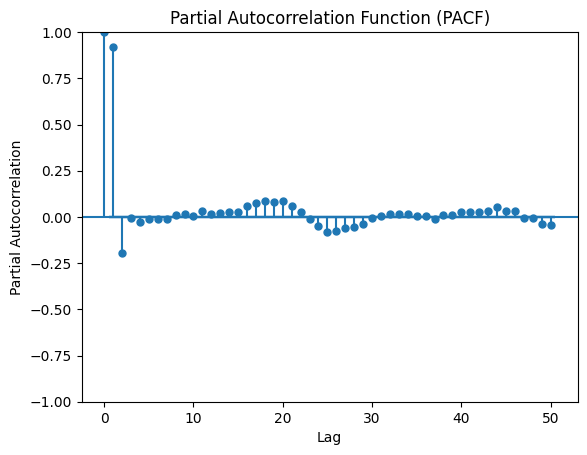

In [100]:
plot_pacf(df, lags=50)  # You can adjust the number of lags as needed
plt.title('Partial Autocorrelation Function (PACF)')
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.show()

## Define Loss and Model

### Loss

#### QD Loss


In [101]:
from tensorflow.keras.utils import register_keras_serializable

In [102]:
tf.keras.utils.set_random_seed(48)
tf.config.experimental.enable_op_determinism()
# for qd_objective
# lambda_ = 0.05 # lambda in loss fn
alpha_ = 0.1  # capturing (1-alpha)% of samples
soften_ = 160. #160
n_ = 128 # batch size
lambda1 = 0.95
lambda2 = 0.05

def change_qd_var(alpha, soften, n, l1, l2):
    global alpha_, soften_, n_, lambda1, lambda2
    alpha_ = alpha
    soften_ = soften
    n_ = n
    lambda1 = l1
    lambda2 = l2

@register_keras_serializable()
def qd_objective(y_true, y_pred):
    '''Loss_QD-soft, from algorithm 1'''
    y_true = y_true[:, 0]
    y_u = y_pred[:, 0]
    y_l = y_pred[:, 1]

    K_SU = tf.sigmoid(soften_ * (y_u - y_true))
    K_SL = tf.sigmoid(soften_ * (y_true - y_l))
    K_S = tf.multiply(K_SU, K_SL)

    # Calculate MPIW_c using tf.cond
    sum_K_S = tf.reduce_sum(K_S)
    numerator_MPIW_c = tf.reduce_sum(tf.multiply((y_u - y_l), K_S))
    MPIW_c = tf.cond(
        pred=tf.equal(sum_K_S, 0),
        true_fn=lambda: tf.constant(0.0, dtype=tf.float32),
        false_fn=lambda: numerator_MPIW_c / (sum_K_S + 1e-8)
    )

    PICP_S = tf.reduce_mean(K_S)

    penalty = tf.maximum(0.0, y_l - y_true) + tf.maximum(0.0, y_true - y_u)
    non_zero_terms = tf.boolean_mask(penalty, penalty > 0)

    # Calculate pen_loss using tf.cond
    size = tf.size(non_zero_terms)
    pen_loss = tf.cond(
        pred=tf.equal(size, 0),
        true_fn=lambda: tf.constant(0.0, dtype=tf.float32),
        false_fn=lambda: tf.reduce_mean(non_zero_terms)
    )

    Loss_S = lambda1 * MPIW_c + \
             lambda2 * n_ / (alpha_ * (1 - alpha_)) * tf.square(tf.maximum(0.0, (1 - alpha_) - PICP_S)) + \
             pen_loss
    return Loss_S

#### Confidence Loss(Tube Loss)

In [103]:
tf.keras.utils.set_random_seed(48)
tf.config.experimental.enable_op_determinism()
# for confidance loss
r= 0.95 # confidence {0-1}
q = 0.95
delta = 0.002 # 0.05,0.1
qq1 = 0.025
qq2 = 0.975

def change_confidence_var(r_, q_, delta_):
    global r, q, delta
    r = r_
    q = q_
    delta = delta_

def confidence_loss(y_true, y_pred):
    y_true = y_true[:, 0]
    f1 = y_pred[:, 0]
    f2 = y_pred[:, 1]

    c1 = (1 - q) * (y_true - f2)
    c2 = (1 - q) * (f1 - y_true)
    c3 = q * (f2 - y_true)
    c4 = q * (y_true - f1)

    condition1 = tf.math.logical_and(y_true <= f1, y_true >= f2)
    condition2 = y_true > (r * f1 + (1 - r) * f2)
    condition3 = f2 > y_true

    loss_part1 = tf.where(condition1,
                          tf.where(condition2, c1, c2),
                          tf.where(condition3, c3, c4))
    loss = loss_part1 + (delta * tf.math.abs(f1 - f2))
    return loss

#### Quantile Loss

In [104]:
tf.keras.utils.set_random_seed(48)
tf.config.experimental.enable_op_determinism()
from tensorflow.keras.saving import register_keras_serializable
@register_keras_serializable()
def quantile_loss(quantile):
    def loss(y_true, y_pred):
        e = y_true - y_pred
        return tf.reduce_mean(tf.maximum(quantile * e, (quantile - 1) * e), axis=-1)
    return loss

### LSTM Model

In [105]:
def create_lstm(input_shape, layer_units, output_units, dropout_rate=0.0):
    model = Sequential()
    for i, units in enumerate(layer_units[:-1]):
        model.add(LSTM(units=units, return_sequences=True, input_shape=input_shape, activation="relu"))
        if dropout_rate > 0.0:
            model.add(Dropout(dropout_rate))  # Adding dropout between LSTM layers
    # Last LSTM layer without return_sequences
    model.add(LSTM(units=layer_units[-1], activation="relu"))
    if dropout_rate > 0.0:
        model.add(Dropout(dropout_rate))  # Adding dropout after the last LSTM layer
    model.add(Dense(output_units))  # Output layer
    return model

### GRU Model


In [106]:
def create_gru(input_shape, layer_units, output_units, dropout_rate=0.0):
    model = Sequential()
    for i, units in enumerate(layer_units[:-1]):
        model.add(GRU(units=units, return_sequences=True, input_shape=input_shape, activation="relu"))
        if dropout_rate > 0.0:
            model.add(Dropout(dropout_rate))  # Adding dropout between GRU layers
    # Last GRU layer without return_sequences
    model.add(GRU(units=layer_units[-1], activation="relu"))
    if dropout_rate > 0.0:
        model.add(Dropout(dropout_rate))  # Adding dropout after the last GRU layer
    model.add(Dense(output_units))  # Output layer
    return model

### TCN Model

In [107]:
# def create_tcn(input_shape, layer_units, output_units, kernel=3, dropout_rate=0.0):
#     model = Sequential()
#     # print(layer_units)
#     i=0
#     for units in layer_units[:-1]:
#         model.add(TCN(nb_filters=units, kernel_size=kernel, nb_stacks=1, dilations=[2**i], dropout_rate=dropout_rate, return_sequences=True,activation='relu'))
#         i=i+1
#     model.add(TCN(nb_filters=layer_units[-1], kernel_size=kernel, nb_stacks=1, dilations=[2**i], dropout_rate=dropout_rate,activation='relu'))
#     model.add(Dense(output_units))  # Output layer
#     return model

In [108]:
from tensorflow.keras.layers import Input, Conv1D, ReLU, Dropout, Add, Flatten, Dense
from tensorflow.keras.models import Model

def tcn_block(x, filters, kernel_size, dilation_rate, dropout_rate):
    original_x = x
    x = Conv1D(filters=filters, kernel_size=kernel_size, padding='causal', dilation_rate=dilation_rate, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    x = Conv1D(filters=filters, kernel_size=kernel_size, padding='causal', dilation_rate=dilation_rate, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    if original_x.shape[-1] != filters:
        original_x = Conv1D(filters=filters, kernel_size=1, padding='same')(original_x)
    x = Add()([original_x, x])
    return x


In [109]:
def create_tcn(input_shape, filters_list, kernel_size, dropout_rate):
    input_layer = Input(shape=input_shape)
    x = input_layer
    dilation_rates = [2**i for i in range(len(filters_list))]
    for filters, dilation_rate in zip(filters_list, dilation_rates):
        x = tcn_block(x, filters, kernel_size, dilation_rate, dropout_rate)
    x = Flatten()(x)
    output_layer = Dense(2)(x)
    model = Model(inputs=input_layer, outputs=output_layer)
    return model

## Train and Test

#### Split Data

In [110]:
input_window_size = 24  # window size

In [111]:
# Time-based train-test split
validation_size = 0.15
test_size = 0.15
split_index_val = int(len(df) * (1 - validation_size - test_size))
split_index_test = int(len(df) * (1 - test_size))

train_data = df[:split_index_val]
validation_data = df[split_index_val:split_index_test]
test_data = df[split_index_test:]

In [112]:
def truncate(x, feature_cols=range(1), target_cols=range(1), label_col=1, train_len=100, test_len=20):
    in_, out_= [], []
    for i in range(len(x)-train_len-test_len+1):
        in_.append(x[i:(i+train_len), feature_cols].tolist())
        out_.append(x[(i+train_len):(i+train_len+test_len), target_cols].tolist())
    return np.array(in_), np.array(out_)

In [113]:
train_x, train_y = truncate(train_data.values, feature_cols=range(1), target_cols=range(1), label_col=1, train_len=input_window_size, test_len=1)
val_x, val_y = truncate(validation_data.values, feature_cols=range(1), target_cols=range(1), label_col=1, train_len=input_window_size, test_len=1)
test_x, test_y = truncate(test_data.values, feature_cols=range(1), target_cols=range(1), label_col=1, train_len=input_window_size, test_len=1)

In [114]:
print("Train shapes:", train_x.shape, train_y.shape)
print("Validation shapes:", val_x.shape, val_y.shape)
print("Test shapes:", test_x.shape, test_y.shape)

Train shapes: (18388, 24, 1) (18388, 1, 1)
Validation shapes: (3922, 24, 1) (3922, 1, 1)
Test shapes: (3922, 24, 1) (3922, 1, 1)


#### MinMax Normalization

In [115]:
# Min-Max normalization for input features
scaler_x = MinMaxScaler()
scaler_x.fit(train_x.reshape(-1, 1))  # Fit scaler only on training data
train_x = scaler_x.transform(train_x.reshape(-1, 1)).reshape(train_x.shape)
val_x = scaler_x.transform(val_x.reshape(-1, 1)).reshape(val_x.shape)
test_x = scaler_x.transform(test_x.reshape(-1, 1)).reshape(test_x.shape)

# Min-Max normalization for target values
scaler_y = MinMaxScaler()
scaler_y.fit(train_y.reshape(-1, 1))  # Fit scaler only on training data
train_y = scaler_y.transform(train_y.reshape(-1, 1)).reshape(train_y.shape)
val_y = scaler_y.transform(val_y.reshape(-1, 1)).reshape(val_y.shape)
test_y = scaler_y.transform(test_y.reshape(-1, 1)).reshape(test_y.shape)

#### Model Train

##### Save to CSV

In [116]:
def save_to_csv(filename, *data):
    try:
        with open(filename, 'a', newline='') as csvfile:
            writer = csv.writer(csvfile)
            writer.writerow(data)
        print("Data appended successfully to", filename)
    except Exception as e:
        print("Error:", e)

# save_to_csv(savefilename, "")

In [117]:
tf.keras.utils.set_random_seed(48)
tf.config.experimental.enable_op_determinism()

##### QD

###### QD LSTM

In [121]:
tf.keras.utils.set_random_seed(48)
tf.config.experimental.enable_op_determinism()
for dropout in [0.1]:
    for layers in [[128]]:
        for alp in [0.05]:
            for sof in [200]:
                for l1 in [2]:
                    for l2 in [0.1]:
                        change_qd_var(alp, sof, 128, l1, l2)
                        QD = create_lstm((input_window_size,1),layers,2,dropout)
                        QD.compile(loss=qd_objective,optimizer=Adam(learning_rate=0.001))
                        epc = 300
                        stop_patience = 10
                        early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=stop_patience, mode='min')
                        start_time = datetime.datetime.now()
                        history = QD.fit(train_x, train_y, epochs=epc, verbose=1, batch_size=128,  validation_data=(val_x, val_y), callbacks=[early_stopping])
                        end_time = datetime.datetime.now()
                        total_time = end_time - start_time
                        total_time = round(total_time.total_seconds(),2)
                        print('seconds taken:', total_time, '\nstart_time:', start_time.strftime('%H:%M:%S'), 'end_time:', end_time.strftime('%H:%M:%S'))
                        y_pred = QD.predict(test_x, verbose=0)
                        y_pred = scaler_y.inverse_transform(y_pred)
                        test_y_ = scaler_y.inverse_transform(test_y.reshape(-1,1))
                        test_y_ = np.squeeze(test_y_[:,0])
                        y_u_pred = y_pred[:,0]
                        y_l_pred = y_pred[:,1]
                        K_u = y_u_pred > test_y_
                        K_l = y_l_pred < test_y_
                        PICP = np.mean(K_u * K_l)
                        MPIW = np.round(np.mean(y_u_pred - y_l_pred),3)
                        print('PICP:', PICP)
                        print('MPIW:', MPIW)
                        save_to_csv("qd_"+savefilename, dataset, "QD_LSTM", PICP, MPIW, total_time, stop_patience, input_window_size, alpha_, soften_, n_, lambda1, lambda2, layers, dropout)
                        print(dataset, "QD_LSTM", PICP, MPIW, total_time, stop_patience, input_window_size, alpha_, soften_, n_, lambda1, lambda2, layers, dropout)


Epoch 1/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - loss: 69.7274 - val_loss: 1.1599
Epoch 2/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - loss: 1.0709 - val_loss: 1.1271
Epoch 3/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - loss: 1.0139 - val_loss: 1.1024
Epoch 4/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - loss: 0.9508 - val_loss: 1.0945
Epoch 5/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - loss: 0.9040 - val_loss: 0.8681
Epoch 6/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - loss: 0.8331 - val_loss: 0.9129
Epoch 7/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - loss: 0.8221 - val_loss: 0.8652
Epoch 8/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - loss: 0.8327 - val_loss: 0.8236
Epoch 9/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - loss: 0.7684 - val_loss: 0.8074
Epoch 10/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - loss: 0.7657 - val_loss: 0.7724
Epoch 11/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - loss: 0.7924 - val_loss: 0.7560
Epoch 12/300
144/144 ━━━━━━━━

In [ ]:
QD.save('S_lstm_qd.keras')

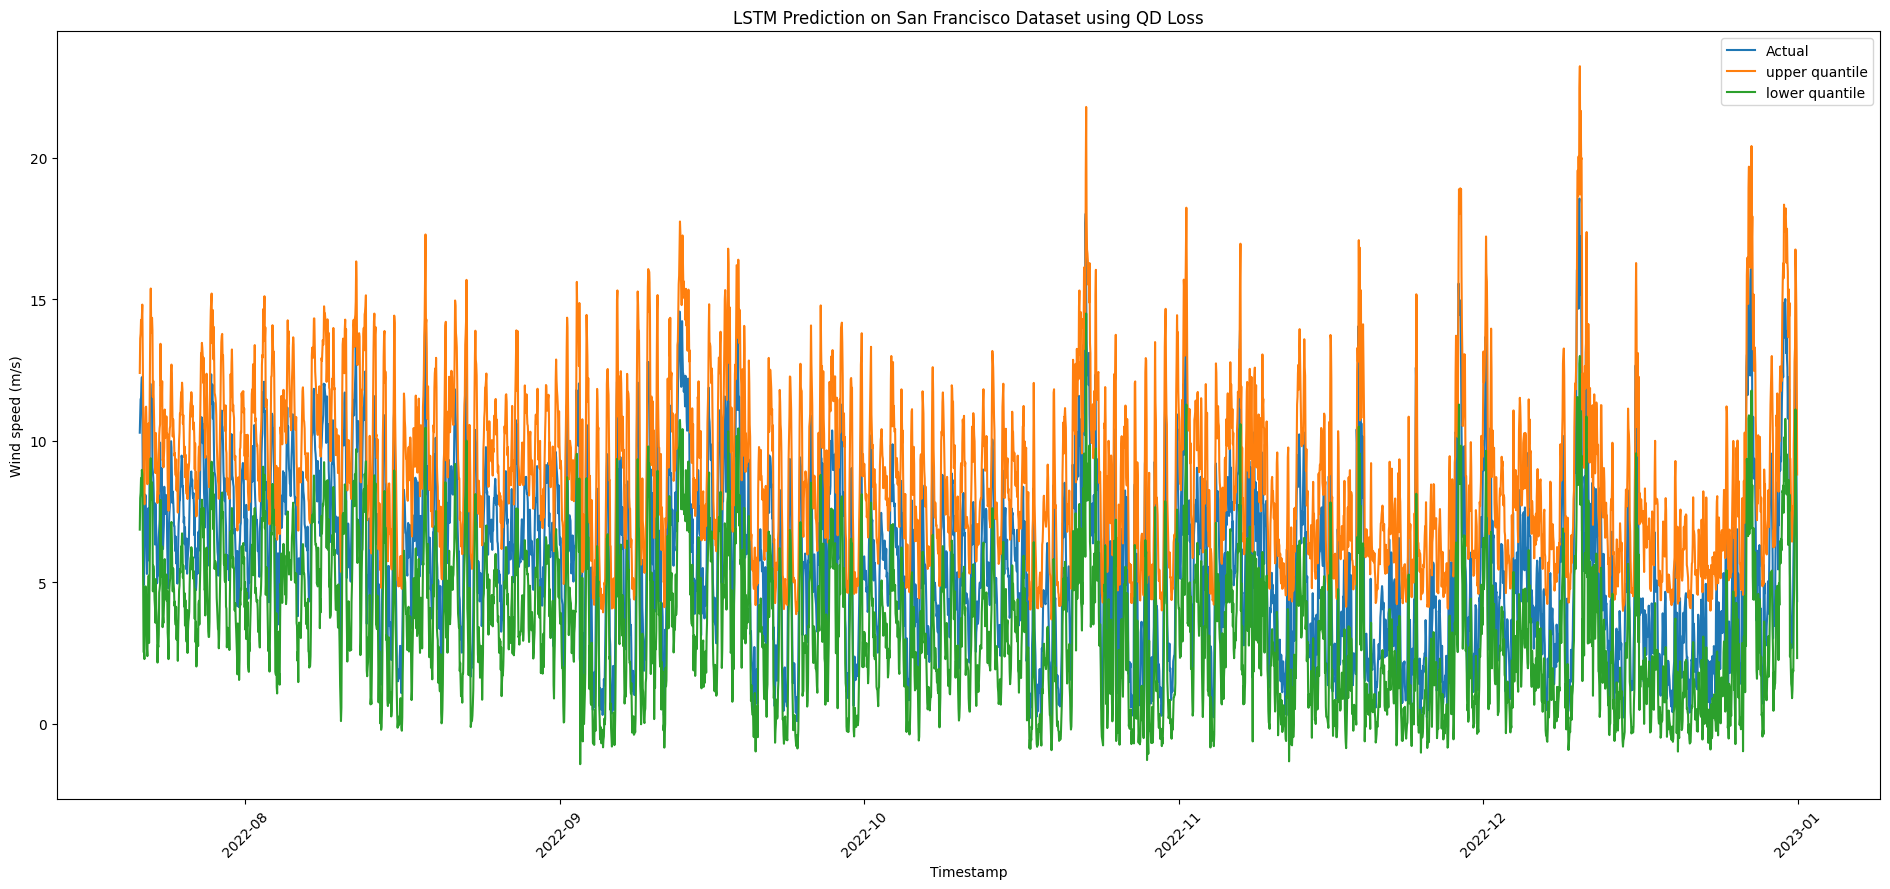

In [ ]:
actual=test_y_
# actual = np.squeeze(actual)
pred1=y_u_pred
pred2=y_l_pred
numEx = test_data.index
numEx = numEx[24:]
plt.figure(figsize=(19, 9))
plt.plot(numEx,actual,label='Actual')
plt.plot(numEx,pred1,label='upper quantile')
plt.plot(numEx,pred2,label='lower quantile')
plt.legend(loc='upper right')
plt.title('LSTM Prediction on San Francisco Dataset using QD Loss')
plt.xlabel('Timestamp')
plt.ylabel('Wind speed (m/s)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('S_lstm_tube')
plt.show()

###### QD GRU

In [124]:
tf.keras.utils.set_random_seed(48)
tf.config.experimental.enable_op_determinism()
for dropout in [0.1]:
    for layers in [[128]]:
        for alp in [0.05]:
            for sof in [300]:
                for l1 in [2]:
                    for l2 in [0.1]:
                        gru_model = create_gru((input_window_size, 1), layers, 2, dropout)
                        change_qd_var(alp, sof, 128, l1, l2)
                        gru_model.compile(loss=qd_objective, optimizer=Adam(learning_rate=0.001))
                        epc = 300
                        stop_patience = 10
                        early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=stop_patience, mode='min')
                        start_time = datetime.datetime.now()
                        history = gru_model.fit(train_x, train_y, epochs=epc, verbose=1, batch_size=128, validation_data=(val_x, val_y), callbacks=[early_stopping])
                        end_time = datetime.datetime.now()
                        total_time = end_time - start_time
                        total_time = round(total_time.total_seconds(), 2)
                        print('seconds taken:', total_time, '\nstart_time:', start_time.strftime('%H:%M:%S'), 'end_time:', end_time.strftime('%H:%M:%S'))
                        y_pred = gru_model.predict(test_x, verbose=0)
                        y_pred = scaler_y.inverse_transform(y_pred)
                        test_y_ = scaler_y.inverse_transform(test_y.reshape(-1,1))
                        test_y_ = np.squeeze(test_y_[:,0])
                        y_u_pred = y_pred[:,0]
                        y_l_pred = y_pred[:,1]
                        K_u = y_u_pred > test_y_
                        K_l = y_l_pred < test_y_
                        PICP = np.mean(K_u * K_l)
                        MPIW = np.round(np.mean(y_u_pred - y_l_pred),3)
                        print('PICP:', PICP)
                        print('MPIW:', MPIW)
                        save_to_csv("qd_"+savefilename, dataset, "QD_GRU", PICP, MPIW, total_time, stop_patience, input_window_size, alpha_, soften_, n_, lambda1, lambda2, layers, dropout)

Epoch 1/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - loss: 78.6366 - val_loss: 1.0478
Epoch 2/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 1.0258 - val_loss: 0.9439
Epoch 3/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 0.9224 - val_loss: 0.9561
Epoch 4/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 0.8661 - val_loss: 0.9131
Epoch 5/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 0.8079 - val_loss: 0.8388
Epoch 6/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 0.7575 - val_loss: 0.7925
Epoch 7/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 0.7212 - val_loss: 0.7417
Epoch 8/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - loss: 0.7086 - val_loss: 0.7231
Epoch 9/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - loss: 0.6894 - val_loss: 0.7136
Epoch 10/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - loss: 0.7014 - val_loss: 0.7243
Epoch 11/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - loss: 0.6633 - val_loss: 0.6959
Epoch 12/300
144/144 ━━━━━━━━

In [ ]:
gru_model.save('S_gru_qd.keras')

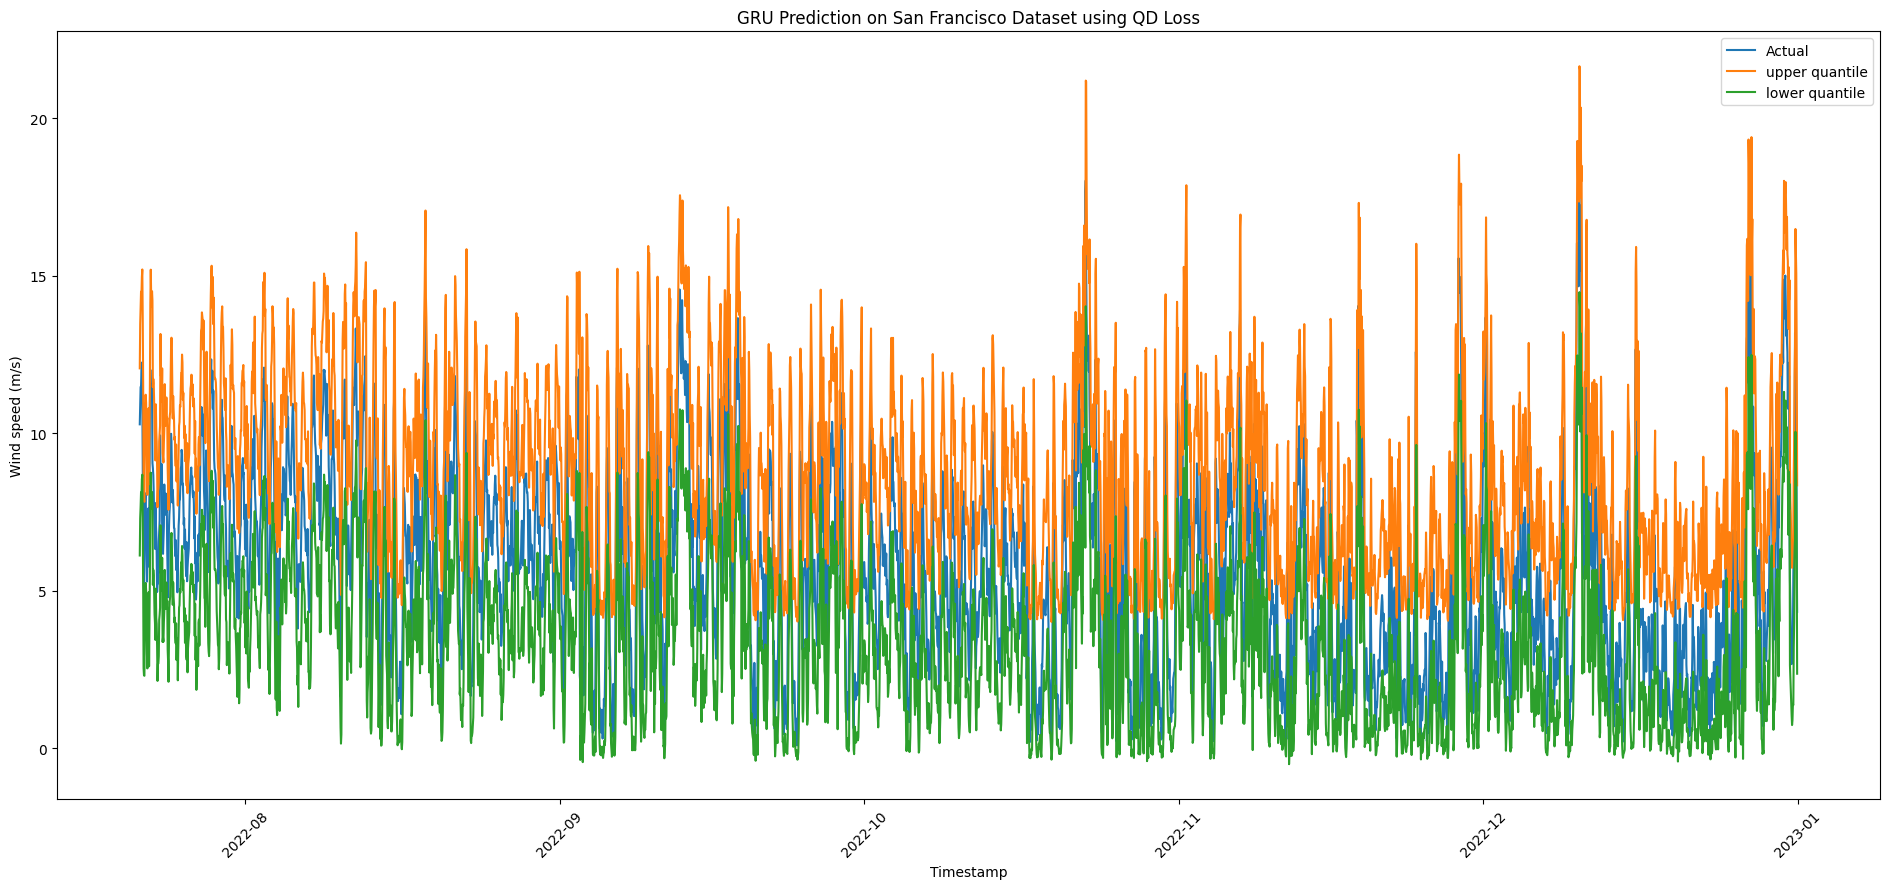

In [ ]:
actual=test_y_
# actual = np.squeeze(actual)
pred1=y_u_pred
pred2=y_l_pred
numEx = test_data.index
numEx = numEx[24:]
plt.figure(figsize=(19, 9))
plt.plot(numEx,actual,label='Actual')
plt.plot(numEx,pred1,label='upper quantile')
plt.plot(numEx,pred2,label='lower quantile')
plt.legend(loc='upper right')
plt.title('GRU Prediction on San Francisco Dataset using QD Loss')
plt.xlabel('Timestamp')
plt.ylabel('Wind speed (m/s)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('S_lstm_tube')
plt.show()

###### QD TCN

In [131]:
tf.keras.utils.set_random_seed(48)
tf.config.experimental.enable_op_determinism()
for dropout in [0.1]:
    for kernel in [3]:
        for layers in [[128]]:
            for alp in [0.05]:
                for sof in [300]:
                    for l1 in [2]:
                        for l2 in [0.1]:
                            change_qd_var(alp, sof, 128, l1, l2)
                            tcn_model = create_tcn((input_window_size,1), layers, kernel, dropout)
                            tcn_model.compile(loss=qd_objective, optimizer=Adam(learning_rate=0.001))
                            epc = 300
                            stop_patience = 10
                            early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=stop_patience, mode='min')
                            start_time = datetime.datetime.now()
                            history = tcn_model.fit(train_x, train_y, epochs=epc, verbose=1, batch_size=128, validation_data=(val_x, val_y), callbacks=[early_stopping])
                            end_time = datetime.datetime.now()
                            total_time = end_time - start_time
                            total_time = round(total_time.total_seconds(), 2)
                            print('seconds taken:', total_time, '\nstart_time:', start_time.strftime('%H:%M:%S'), 'end_time:', end_time.strftime('%H:%M:%S'))
                            y_pred = tcn_model.predict(test_x, verbose=0)
                            y_pred = scaler_y.inverse_transform(y_pred)
                            test_y_ = scaler_y.inverse_transform(test_y.reshape(-1,1))
                            test_y_ = np.squeeze(test_y_[:,0])
                            y_u_pred = y_pred[:,0]
                            y_l_pred = y_pred[:,1]
                            K_u = y_u_pred > test_y_
                            K_l = y_l_pred < test_y_
                            PICP = np.mean(K_u * K_l)
                            MPIW = np.round(np.mean(y_u_pred - y_l_pred), 3)
                            print('PICP:', PICP)
                            print('MPIW:', MPIW)
                            save_to_csv("qd_"+savefilename, dataset, "TCN", PICP, MPIW, total_time, stop_patience, input_window_size, alpha_, soften_, n_, lambda1, lambda2, layers, dropout, kernel, "improve")

Epoch 1/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - loss: 63.1848 - val_loss: 1.2722
Epoch 2/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 1.2804 - val_loss: 1.0387
Epoch 3/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 1.0174 - val_loss: 1.1443
Epoch 4/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.9175 - val_loss: 1.8468
Epoch 5/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 1.0148 - val_loss: 1.5222
Epoch 6/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.9093 - val_loss: 0.9079
Epoch 7/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.7328 - val_loss: 0.7695
Epoch 8/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.7280 - val_loss: 0.8511
Epoch 9/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.6691 - val_loss: 0.8783
Epoch 10/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.7105 - val_loss: 0.8484
Epoch 11/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.6927 - val_loss: 0.8940
Epoch 12/300
144/144 ━━━━━━━━

In [ ]:
tcn_model.save('S_tcn_qd.keras')

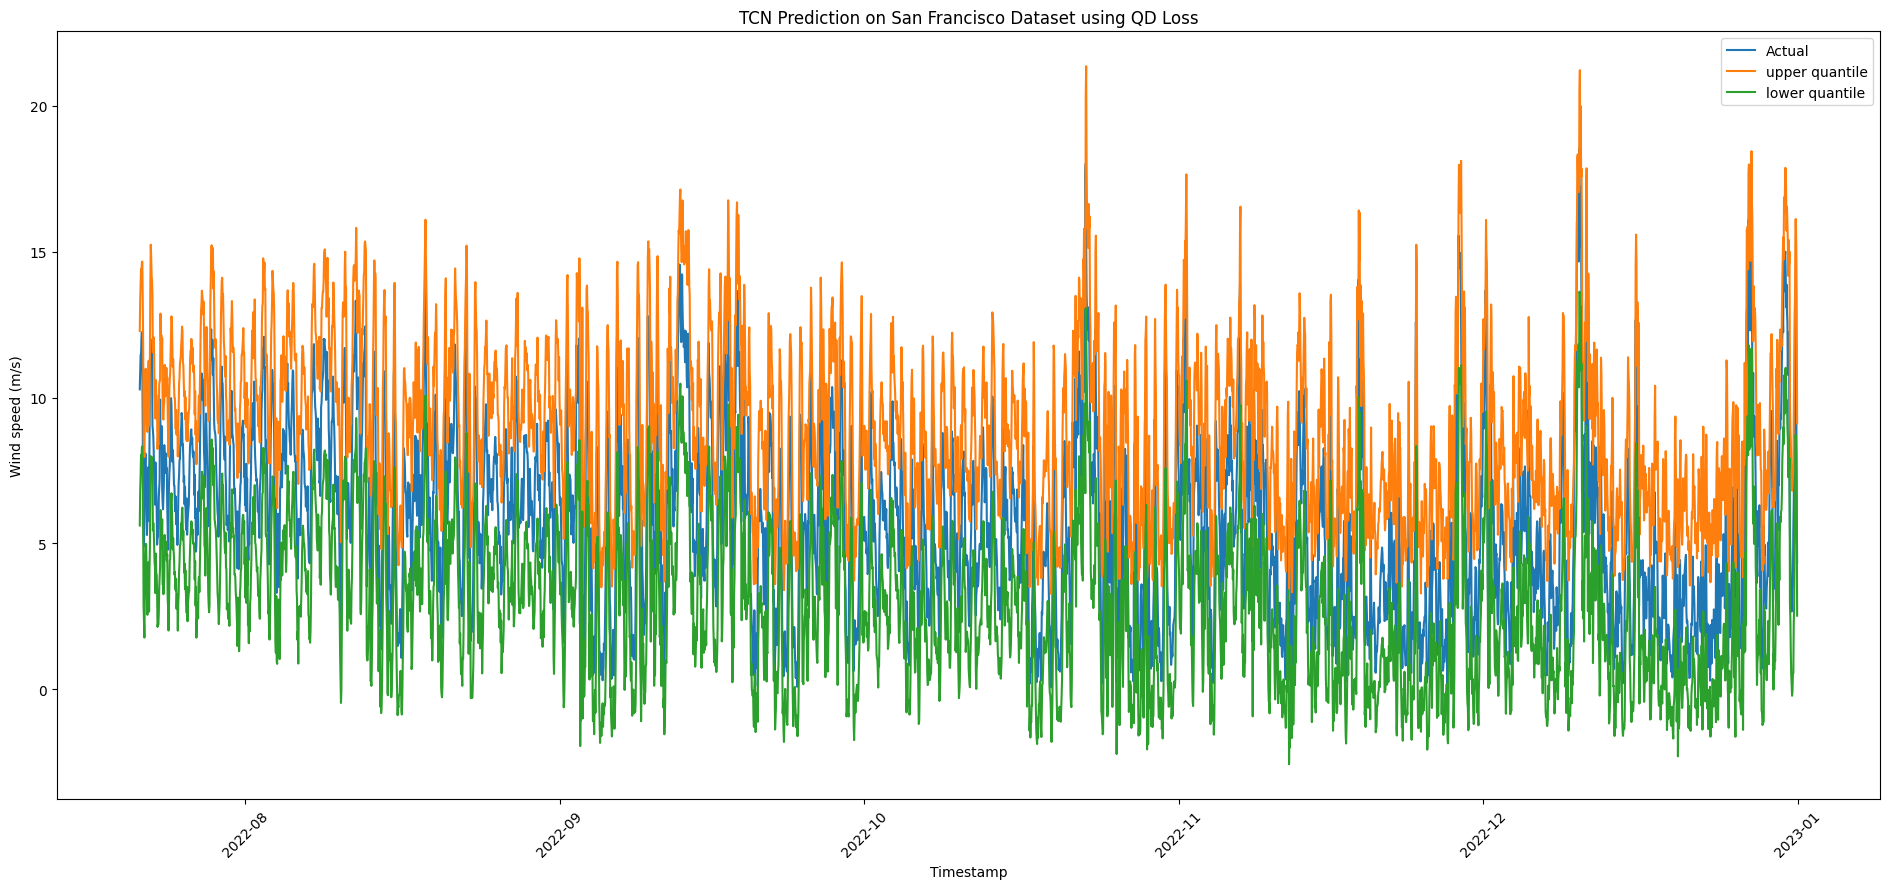

In [ ]:
actual=test_y_
# actual = np.squeeze(actual)
pred1=y_u_pred
pred2=y_l_pred
numEx = test_data.index
numEx = numEx[24:]
plt.figure(figsize=(19, 9))
plt.plot(numEx,actual,label='Actual')
plt.plot(numEx,pred1,label='upper quantile')
plt.plot(numEx,pred2,label='lower quantile')
plt.legend(loc='upper right')
plt.title('TCN Prediction on San Francisco Dataset using QD Loss')
plt.xlabel('Timestamp')
plt.ylabel('Wind speed (m/s)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('S_lstm_tube')
plt.show()

##### Confidence Loss

###### Confidence LSTM

In [136]:
tf.keras.utils.set_random_seed(48)
tf.config.experimental.enable_op_determinism()
for layers in [[32,32]]:
    for ri in [0.5]:
        for qi in [0.95]:
            for deltai in [0.001]:
                change_confidence_var(ri, qi, deltai)
                Confidence = create_lstm((input_window_size,1),layers,2)
                Confidence.compile(loss=confidence_loss,optimizer=Adam(learning_rate=0.001))
                epc = 300
                stop_patience = 10
                early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=stop_patience, mode='min')
                start_time = datetime.datetime.now()
                history = Confidence.fit(train_x, train_y, epochs=epc, verbose=1, batch_size=128,  validation_data=(val_x, val_y), callbacks=[early_stopping])
                end_time = datetime.datetime.now()
                total_time = end_time - start_time
                total_time = round(total_time.total_seconds(),2)
                print('seconds taken:', total_time, '\nstart_time:', start_time.strftime('%H:%M:%S'), 'end_time:', end_time.strftime('%H:%M:%S'))
                y_pred = Confidence.predict(test_x, verbose=0)
                y_pred = scaler_y.inverse_transform(y_pred)
                test_y_ = scaler_y.inverse_transform(test_y.reshape(-1,1))
                test_y_ = np.squeeze(test_y_[:,0])
                y_u_pred = y_pred[:,0]
                y_l_pred = y_pred[:,1]
                K_u = y_u_pred > test_y_
                K_l = y_l_pred < test_y_
                PICP = np.mean(K_u * K_l)
                MPIW = np.round(np.mean(y_u_pred - y_l_pred),3)
                print('PICP:', PICP)
                print('MPIW:', MPIW)
                save_to_csv(savefilename, dataset, "Confidence_LSTM", PICP, MPIW, total_time, stop_patience, input_window_size, r, q, delta, layers)

Epoch 1/300


d:\Python3.11\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


144/144 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - loss: 0.0806 - val_loss: 0.0187
Epoch 2/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.0173 - val_loss: 0.0154
Epoch 3/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.0142 - val_loss: 0.0127
Epoch 4/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0122 - val_loss: 0.0122
Epoch 5/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - loss: 0.0111 - val_loss: 0.0110
Epoch 6/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.0104 - val_loss: 0.0108
Epoch 7/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.0100 - val_loss: 0.0107
Epoch 8/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0099 - val_loss: 0.0104
Epoch 9/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0099 - val_loss: 0.0103
Epoch 10/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.0098 - val_loss: 0.0102
Epoch 11/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0098 - val_loss: 0.0102
Epoch 12/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
Confidence.save('S_LSTM_Confidence.keras')

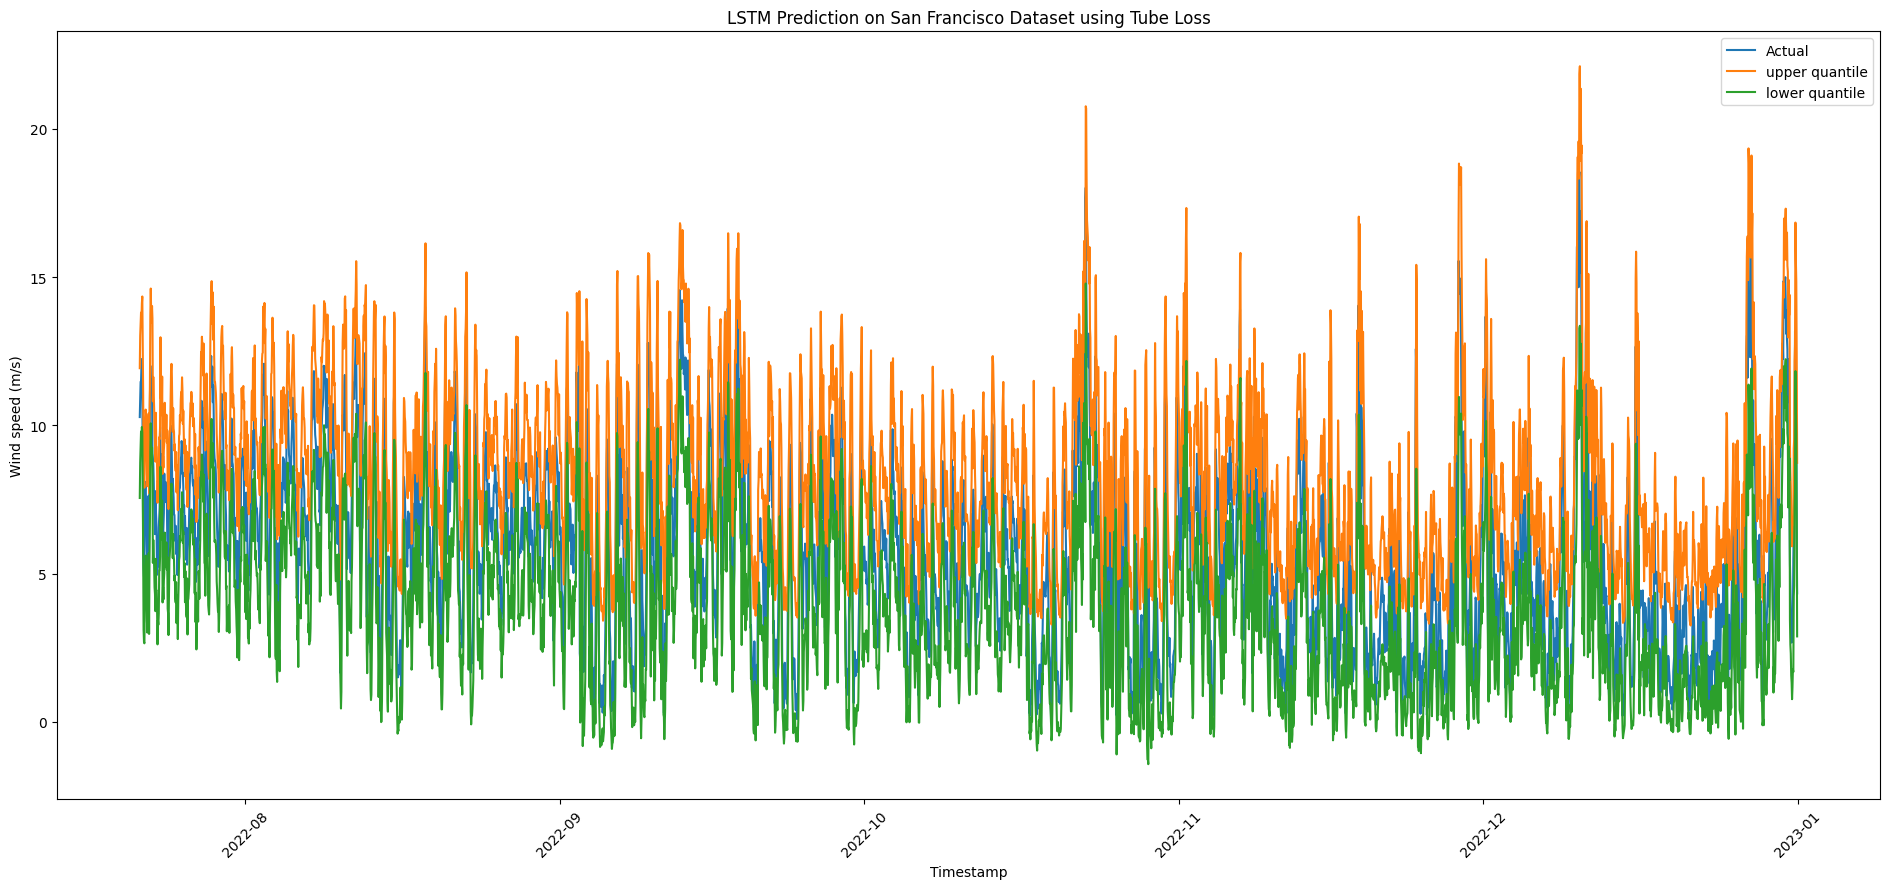

In [ ]:
actual=test_y_
# actual = np.squeeze(actual)
pred1=y_u_pred
pred2=y_l_pred
numEx = test_data.index
numEx = numEx[24:]
plt.figure(figsize=(19, 9))
plt.plot(numEx,actual,label='Actual')
plt.plot(numEx,pred1,label='upper quantile')
plt.plot(numEx,pred2,label='lower quantile')
plt.legend(loc='upper right')
plt.title('LSTM Prediction on San Francisco Dataset using Tube Loss')
plt.xlabel('Timestamp')
plt.ylabel('Wind speed (m/s)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('S_lstm_tube')
plt.show()

###### Confidence GRU

In [141]:
tf.keras.utils.set_random_seed(48)
tf.config.experimental.enable_op_determinism()
for dropout in [0.1]:
    for layers in [[16,16]]:
        for ri in [0.5]:
            for qi in [0.95]:
                for deltai in [0.005]:
                    change_confidence_var(ri, qi, deltai)
                    Confidence_GRU = create_gru((input_window_size,1),layers,2,dropout)
                    Confidence_GRU.compile(loss=confidence_loss,optimizer=Adam(learning_rate=0.001))
                    epc = 300
                    stop_patience = 10
                    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=stop_patience, mode='min')
                    start_time = datetime.datetime.now()
                    history = Confidence_GRU.fit(train_x, train_y, epochs=epc, verbose=1, batch_size=128,  validation_data=(val_x, val_y), callbacks=[early_stopping])
                    end_time = datetime.datetime.now()
                    total_time = end_time - start_time
                    total_time = round(total_time.total_seconds(),2)
                    print('seconds taken:', total_time, '\nstart_time:', start_time.strftime('%H:%M:%S'), 'end_time:', end_time.strftime('%H:%M:%S'))
                    y_pred = Confidence_GRU.predict(test_x, verbose=0)
                    y_pred = scaler_y.inverse_transform(y_pred)
                    test_y_ = scaler_y.inverse_transform(test_y.reshape(-1,1))
                    test_y_ = np.squeeze(test_y_[:,0])
                    y_u_pred = y_pred[:,0]
                    y_l_pred = y_pred[:,1]
                    K_u = y_u_pred > test_y_
                    K_l = y_l_pred < test_y_
                    PICP = np.mean(K_u * K_l)
                    MPIW = np.round(np.mean(y_u_pred - y_l_pred),3)
                    print('PICP:', PICP)
                    print('MPIW:', MPIW)
                    save_to_csv(savefilename, dataset, "Confidence_GRU", PICP, MPIW, total_time, stop_patience, input_window_size, r, q, delta,layers, dropout)


d:\Python3.11\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 13s 39ms/step - loss: 0.0945 - val_loss: 0.0183
Epoch 2/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 0.0192 - val_loss: 0.0158
Epoch 3/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 0.0169 - val_loss: 0.0143
Epoch 4/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.0154 - val_loss: 0.0138
Epoch 5/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0145 - val_loss: 0.0131
Epoch 6/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0137 - val_loss: 0.0126
Epoch 7/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0133 - val_loss: 0.0125
Epoch 8/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 0.0130 - val_loss: 0.0120
Epoch 9/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.0127 - val_loss: 0.0120
Epoch 10/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.0123 - val_loss: 0.0117
Epoch 11/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.0122 - val_loss: 0.0118
Epoch 12/300
144/144 ━━━━━━━━

In [ ]:
Confidence_GRU.save('S_GRU_Confidence.keras')

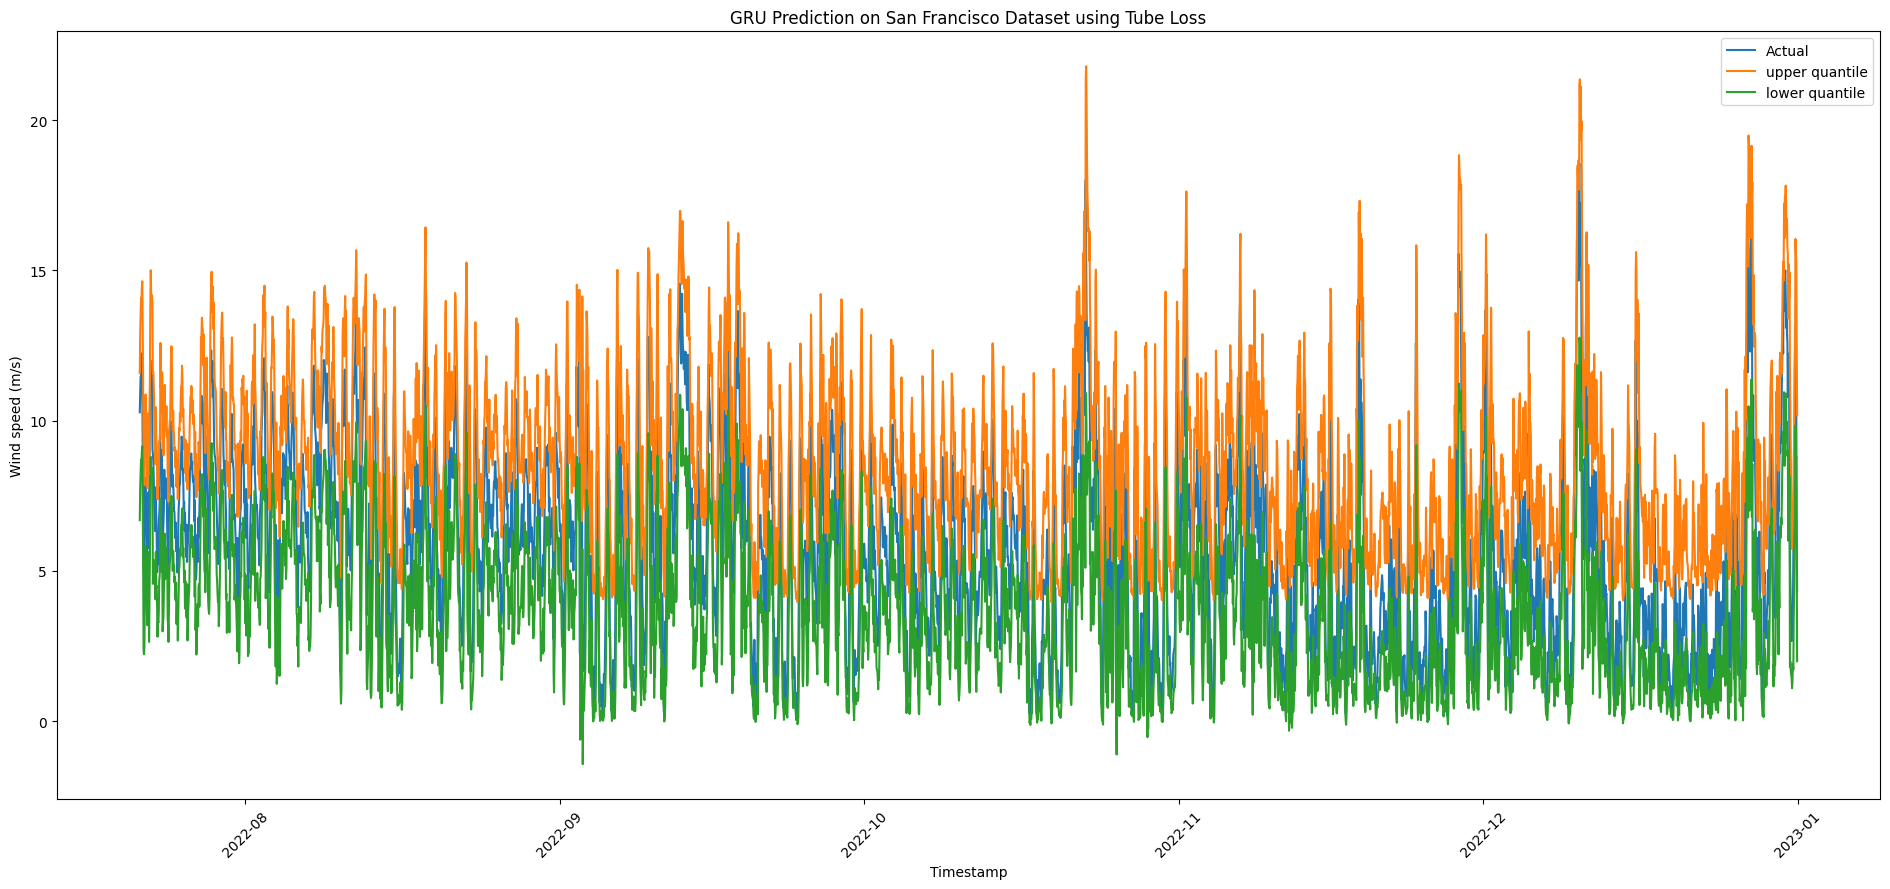

In [ ]:
actual=test_y_
# actual = np.squeeze(actual)
pred1=y_u_pred
pred2=y_l_pred
numEx = test_data.index
numEx = numEx[24:]
plt.figure(figsize=(19, 9))
plt.plot(numEx,actual,label='Actual')
plt.plot(numEx,pred1,label='upper quantile')
plt.plot(numEx,pred2,label='lower quantile')
plt.legend(loc='upper right')
plt.title('GRU Prediction on San Francisco Dataset using Tube Loss')
plt.xlabel('Timestamp')
plt.ylabel('Wind speed (m/s)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('S_lstm_tube')
plt.show()

###### Confidence TCN

In [150]:
tf.keras.utils.set_random_seed(48)
tf.config.experimental.enable_op_determinism()
for dropout in [0.1]:
    for kernel in [3]:
        for layers in [[128]]:
            for ri in [0.5]:
                for qi in [0.95]:
                    for deltai in [0.01]:
                        change_confidence_var(ri, qi, deltai)
                        tcn_Confidence = create_tcn(input_shape=(input_window_size,1),
                                               filters_list=layers,
                                               kernel_size=kernel,
                                               dropout_rate=dropout)
                        tcn_Confidence.compile(loss=confidence_loss, optimizer=Adam(learning_rate=0.001))
                        epc = 300
                        stop_patience = 10
                        early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=stop_patience, mode='min')
                        start_time = datetime.datetime.now()
                        history = tcn_Confidence.fit(train_x, train_y, epochs=epc, verbose=1, batch_size=128, validation_data=(val_x, val_y), callbacks=[early_stopping])
                        end_time = datetime.datetime.now()
                        total_time = end_time - start_time
                        total_time = round(total_time.total_seconds(),2)
                        print('seconds taken:', total_time, '\nstart_time:', start_time.strftime('%H:%M:%S'), 'end_time:', end_time.strftime('%H:%M:%S'))
                        y_pred = tcn_Confidence.predict(test_x, verbose=0)
                        y_pred = scaler_y.inverse_transform(y_pred)
                        test_y_ = scaler_y.inverse_transform(test_y.reshape(-1,1))
                        test_y_ = np.squeeze(test_y_[:,0])
                        y_u_pred = y_pred[:,0]
                        y_l_pred = y_pred[:,1]
                        K_u = y_u_pred > test_y_
                        K_l = y_l_pred < test_y_
                        PICP = np.mean(K_u * K_l)
                        MPIW = np.round(np.mean(y_u_pred - y_l_pred),3)
                        print('PICP:', PICP)
                        print('MPIW:', MPIW)
                        save_to_csv(savefilename, dataset, "Confidence_TCN", PICP, MPIW, total_time, stop_patience, input_window_size, r, q, delta, layers, dropout, kernel)

Epoch 1/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.0397 - val_loss: 0.0138
Epoch 2/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0131 - val_loss: 0.0124
Epoch 3/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0118 - val_loss: 0.0119
Epoch 4/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0118 - val_loss: 0.0119
Epoch 5/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0115 - val_loss: 0.0122
Epoch 6/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0115 - val_loss: 0.0124
Epoch 7/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0114 - val_loss: 0.0123
Epoch 8/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0112 - val_loss: 0.0118
Epoch 9/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0112 - val_loss: 0.0118
Epoch 10/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0111 - val_loss: 0.0117
Epoch 11/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0110 - val_loss: 0.0120
Epoch 12/300
144/144 ━━━━━━━━━

In [ ]:
tcn_Confidence.save('S_TCN_Confidence.keras')

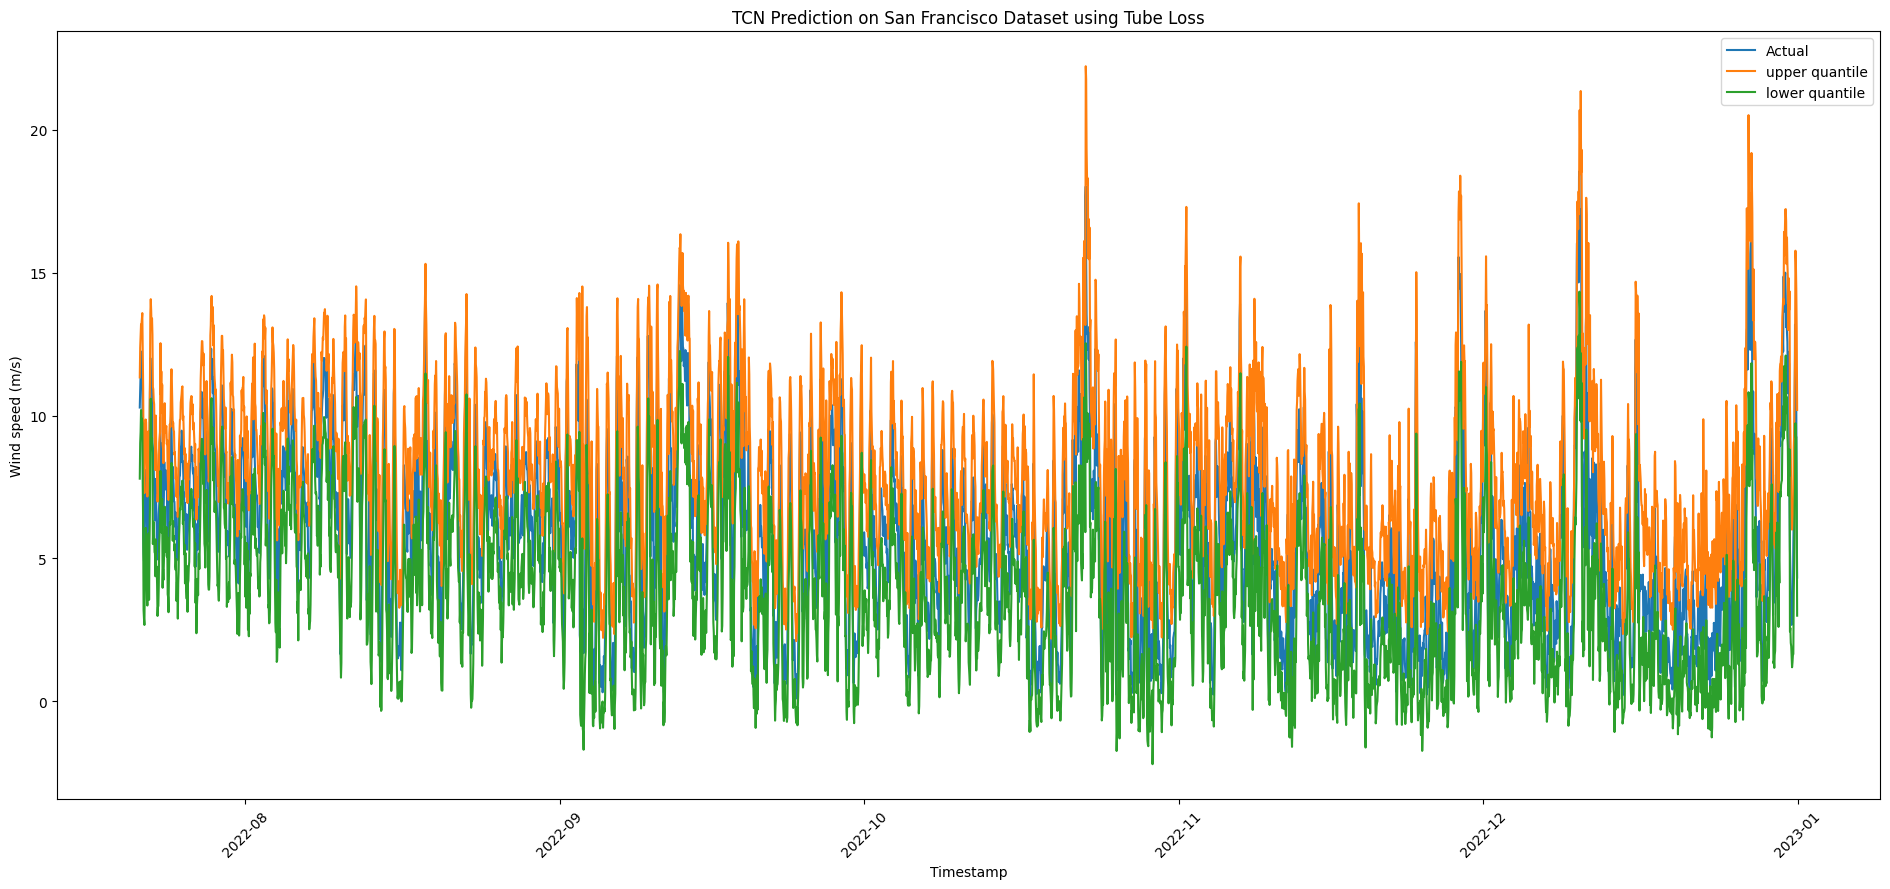

In [ ]:
actual=test_y_
# actual = np.squeeze(actual)
pred1=y_u_pred
pred2=y_l_pred
numEx = test_data.index
numEx = numEx[24:]
plt.figure(figsize=(19, 9))
plt.plot(numEx,actual,label='Actual')
plt.plot(numEx,pred1,label='upper quantile')
plt.plot(numEx,pred2,label='lower quantile')
plt.legend(loc='upper right')
plt.title('TCN Prediction on San Francisco Dataset using Tube Loss')
plt.xlabel('Timestamp')
plt.ylabel('Wind speed (m/s)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('S_lstm_tube')
plt.show()

##### Quantile Loss

###### Quantile LSTM

In [160]:
tf.keras.utils.set_random_seed(48)
tf.config.experimental.enable_op_determinism()
layers = [64]
dropout = 0
quantile1 = create_lstm((input_window_size,1),layers,1,dropout)
quantile2 = create_lstm((input_window_size,1),layers,1,dropout)

In [161]:
tf.keras.utils.set_random_seed(48)
tf.config.experimental.enable_op_determinism()
q1=0.015
q2=0.965
quantile1.compile(loss=quantile_loss(q1),optimizer=Adam(learning_rate=0.001))
quantile2.compile(loss=quantile_loss(q2),optimizer=Adam(learning_rate=0.001))

In [162]:
tf.keras.utils.set_random_seed(48)
tf.config.experimental.enable_op_determinism()
epc = 300
stop_patience = 10
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=stop_patience, mode='min')
start_time = datetime.datetime.now()
history = quantile1.fit(train_x, train_y, epochs=epc, verbose=1, batch_size=128,  validation_data=(val_x, val_y), callbacks=[early_stopping])
end_time = datetime.datetime.now()
total_time = end_time - start_time
total_time1 = round(total_time.total_seconds(),2)
print('seconds taken:', total_time1,
	'\nstart_time:', start_time.strftime('%H:%M:%S'),
	'end_time:', end_time.strftime('%H:%M:%S'))

Epoch 1/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - loss: 0.0036 - val_loss: 0.0035
Epoch 2/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0031 - val_loss: 0.0031
Epoch 3/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0029 - val_loss: 0.0030
Epoch 4/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0027 - val_loss: 0.0029
Epoch 5/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0026 - val_loss: 0.0028
Epoch 6/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0026 - val_loss: 0.0028
Epoch 7/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0025 - val_loss: 0.0028
Epoch 8/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0025 - val_loss: 0.0028
Epoch 9/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0025 - val_loss: 0.0027
Epoch 10/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0025 - val_loss: 0.0028
Epoch 11/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0025 - val_loss: 0.0028
Epoch 12/300
144/144 ━━━━━━━━━

In [163]:
tf.keras.utils.set_random_seed(48)
tf.config.experimental.enable_op_determinism()
epc = 300
stop_patience = 10
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=stop_patience, mode='min')
start_time = datetime.datetime.now()
history = quantile2.fit(train_x, train_y, epochs=epc, verbose=1, batch_size=128,  validation_data=(val_x, val_y), callbacks=[early_stopping])
end_time = datetime.datetime.now()
total_time = end_time - start_time
total_time2 = round(total_time.total_seconds(),2)
print('seconds taken:', total_time2,
	'\nstart_time:', start_time.strftime('%H:%M:%S'),
	'end_time:', end_time.strftime('%H:%M:%S'))

Epoch 1/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - loss: 0.0677 - val_loss: 0.0095
Epoch 2/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0089 - val_loss: 0.0075
Epoch 3/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0071 - val_loss: 0.0065
Epoch 4/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0061 - val_loss: 0.0060
Epoch 5/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.0058 - val_loss: 0.0058
Epoch 6/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0056 - val_loss: 0.0058
Epoch 7/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0055 - val_loss: 0.0056
Epoch 8/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0054 - val_loss: 0.0055
Epoch 9/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0054 - val_loss: 0.0056
Epoch 10/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0053 - val_loss: 0.0055
Epoch 11/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0053 - val_loss: 0.0055
Epoch 12/300
144/144 ━━━━━━━━━

In [164]:
y_l_pred = quantile1.predict(test_x, verbose=0)
y_u_pred = quantile2.predict(test_x, verbose=0)
test_y_ = scaler_y.inverse_transform(test_y.reshape(-1,1))
# test_y_ = np.squeeze(test_y_[:,0])
y_l_pred = scaler_y.inverse_transform(y_l_pred)
y_u_pred = scaler_y.inverse_transform(y_u_pred)
K_u = y_u_pred > test_y_
K_l = y_l_pred < test_y_
PICP = np.mean(K_u * K_l)
MPIW = np.round(np.mean(y_u_pred - y_l_pred),3)
print('PICP:', PICP)
print('MPIW:', MPIW)

PICP: 0.958694543600204
MPIW: 4.978


In [165]:
save_to_csv("quantile_"+savefilename, dataset, "Quantile_LSTM", PICP, MPIW, total_time1 + total_time2, stop_patience, input_window_size, q1, q2, layers, dropout)

Data appended successfully to quantile_san_francisco.csv


In [166]:
quantile1.save('S_lstm_q1.keras')
quantile2.save('S_lstm_q2.keras')

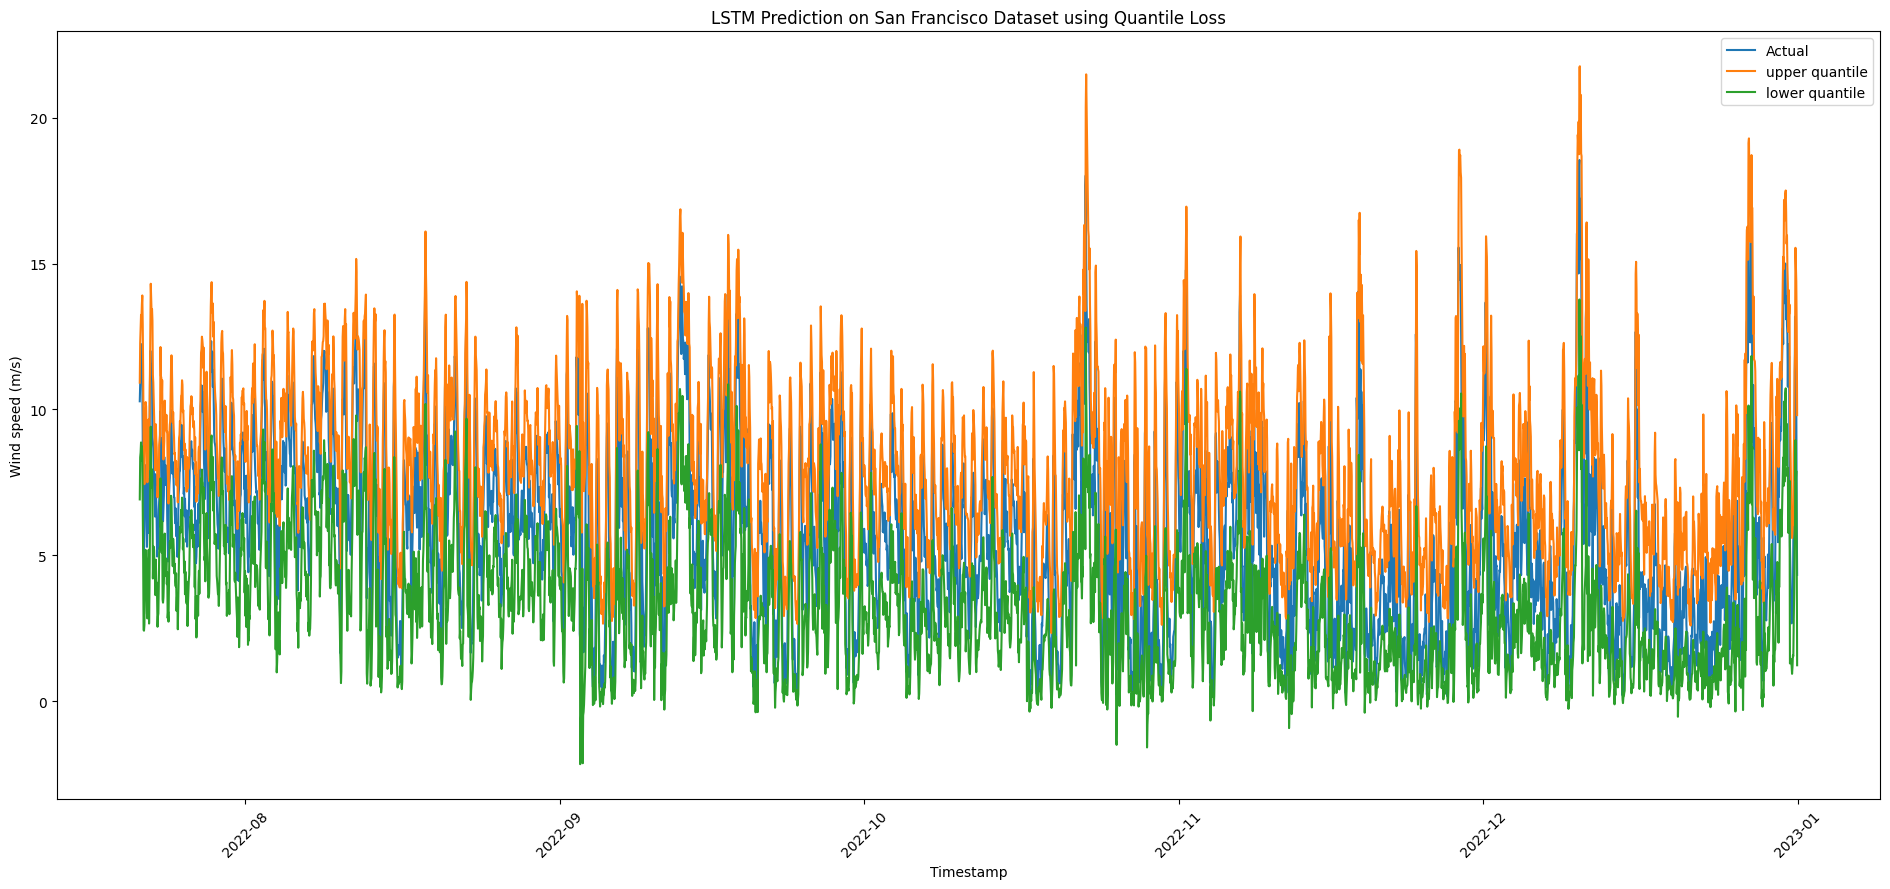

In [ ]:
actual=test_y_
# actual = np.squeeze(actual)
pred1=y_u_pred
pred2=y_l_pred
numEx = test_data.index
numEx = numEx[24:]
plt.figure(figsize=(19, 9))
plt.plot(numEx,actual,label='Actual')
plt.plot(numEx,pred1,label='upper quantile')
plt.plot(numEx,pred2,label='lower quantile')
plt.legend(loc='upper right')
plt.title('LSTM Prediction on San Francisco Dataset using Quantile Loss')
plt.xlabel('Timestamp')
plt.ylabel('Wind speed (m/s)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('S_lstm_tube')
plt.show()

###### Quantile GRU

In [176]:
tf.keras.utils.set_random_seed(48)
tf.config.experimental.enable_op_determinism()
layers = [64]
dropout = 0
quantile1 = create_gru((input_window_size,1),layers,1,dropout)
quantile2 = create_gru((input_window_size,1),layers,1,dropout)

In [177]:
tf.keras.utils.set_random_seed(48)
tf.config.experimental.enable_op_determinism()
q1=0.015
q2=0.965
quantile1.compile(loss=quantile_loss(q1),optimizer=Adam(learning_rate=0.001))
quantile2.compile(loss=quantile_loss(q2),optimizer=Adam(learning_rate=0.001))

In [178]:
tf.keras.utils.set_random_seed(48)
tf.config.experimental.enable_op_determinism()
epc = 300
stop_patience = 10
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=stop_patience, mode='min')
start_time = datetime.datetime.now()
history = quantile1.fit(train_x, train_y, epochs=epc, verbose=1, batch_size=128,  validation_data=(val_x, val_y), callbacks=[early_stopping])
end_time = datetime.datetime.now()
total_time = end_time - start_time
total_time1 = round(total_time.total_seconds(),2)
print('seconds taken:', total_time1,
	'\nstart_time:', start_time.strftime('%H:%M:%S'),
	'end_time:', end_time.strftime('%H:%M:%S'))

Epoch 1/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - loss: 0.0035 - val_loss: 0.0032
Epoch 2/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0028 - val_loss: 0.0030
Epoch 3/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0026 - val_loss: 0.0028
Epoch 4/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.0025 - val_loss: 0.0028
Epoch 5/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0025 - val_loss: 0.0027
Epoch 6/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0025 - val_loss: 0.0027
Epoch 7/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0025 - val_loss: 0.0027
Epoch 8/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0024 - val_loss: 0.0027
Epoch 9/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0024 - val_loss: 0.0027
Epoch 10/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0024 - val_loss: 0.0027
Epoch 11/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0024 - val_loss: 0.0027
Epoch 12/300
144/144 ━━━━━━━━━

In [179]:
tf.keras.utils.set_random_seed(48)
tf.config.experimental.enable_op_determinism()
epc = 300
stop_patience = 10
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=stop_patience, mode='min')
start_time = datetime.datetime.now()
history = quantile2.fit(train_x, train_y, epochs=epc, verbose=1, batch_size=128,  validation_data=(val_x, val_y), callbacks=[early_stopping])
end_time = datetime.datetime.now()
total_time = end_time - start_time
total_time2 = round(total_time.total_seconds(),2)
print('seconds taken:', total_time2,
	'\nstart_time:', start_time.strftime('%H:%M:%S'),
	'end_time:', end_time.strftime('%H:%M:%S'))

Epoch 1/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - loss: 0.0661 - val_loss: 0.0073
Epoch 2/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0069 - val_loss: 0.0067
Epoch 3/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0062 - val_loss: 0.0064
Epoch 4/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0058 - val_loss: 0.0061
Epoch 5/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.0056 - val_loss: 0.0059
Epoch 6/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0055 - val_loss: 0.0058
Epoch 7/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0054 - val_loss: 0.0057
Epoch 8/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0054 - val_loss: 0.0056
Epoch 9/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0053 - val_loss: 0.0055
Epoch 10/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0053 - val_loss: 0.0055
Epoch 11/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0053 - val_loss: 0.0055
Epoch 12/300
144/144 ━━━━━━━━━

In [180]:
y_l_pred = quantile1.predict(test_x, verbose=0)
y_u_pred = quantile2.predict(test_x, verbose=0)
test_y_ = scaler_y.inverse_transform(test_y.reshape(-1,1))
# test_y_ = np.squeeze(test_y_[:,0])
y_l_pred = scaler_y.inverse_transform(y_l_pred)
y_u_pred = scaler_y.inverse_transform(y_u_pred)
K_u = y_u_pred > test_y_
K_l = y_l_pred < test_y_
PICP = np.mean(K_u * K_l)
MPIW = np.round(np.mean(y_u_pred - y_l_pred),3)
print('PICP:', PICP)
print('MPIW:', MPIW)

PICP: 0.9584395716471188
MPIW: 4.952


In [181]:
save_to_csv("quantile_"+savefilename, dataset, "Quantile_GRU", PICP, MPIW, total_time1 + total_time2, stop_patience, input_window_size, q1, q2, layers, dropout)

Data appended successfully to quantile_san_francisco.csv


In [182]:
quantile1.save('S_gru_q1.keras')
quantile2.save('S_gru_q2.keras')

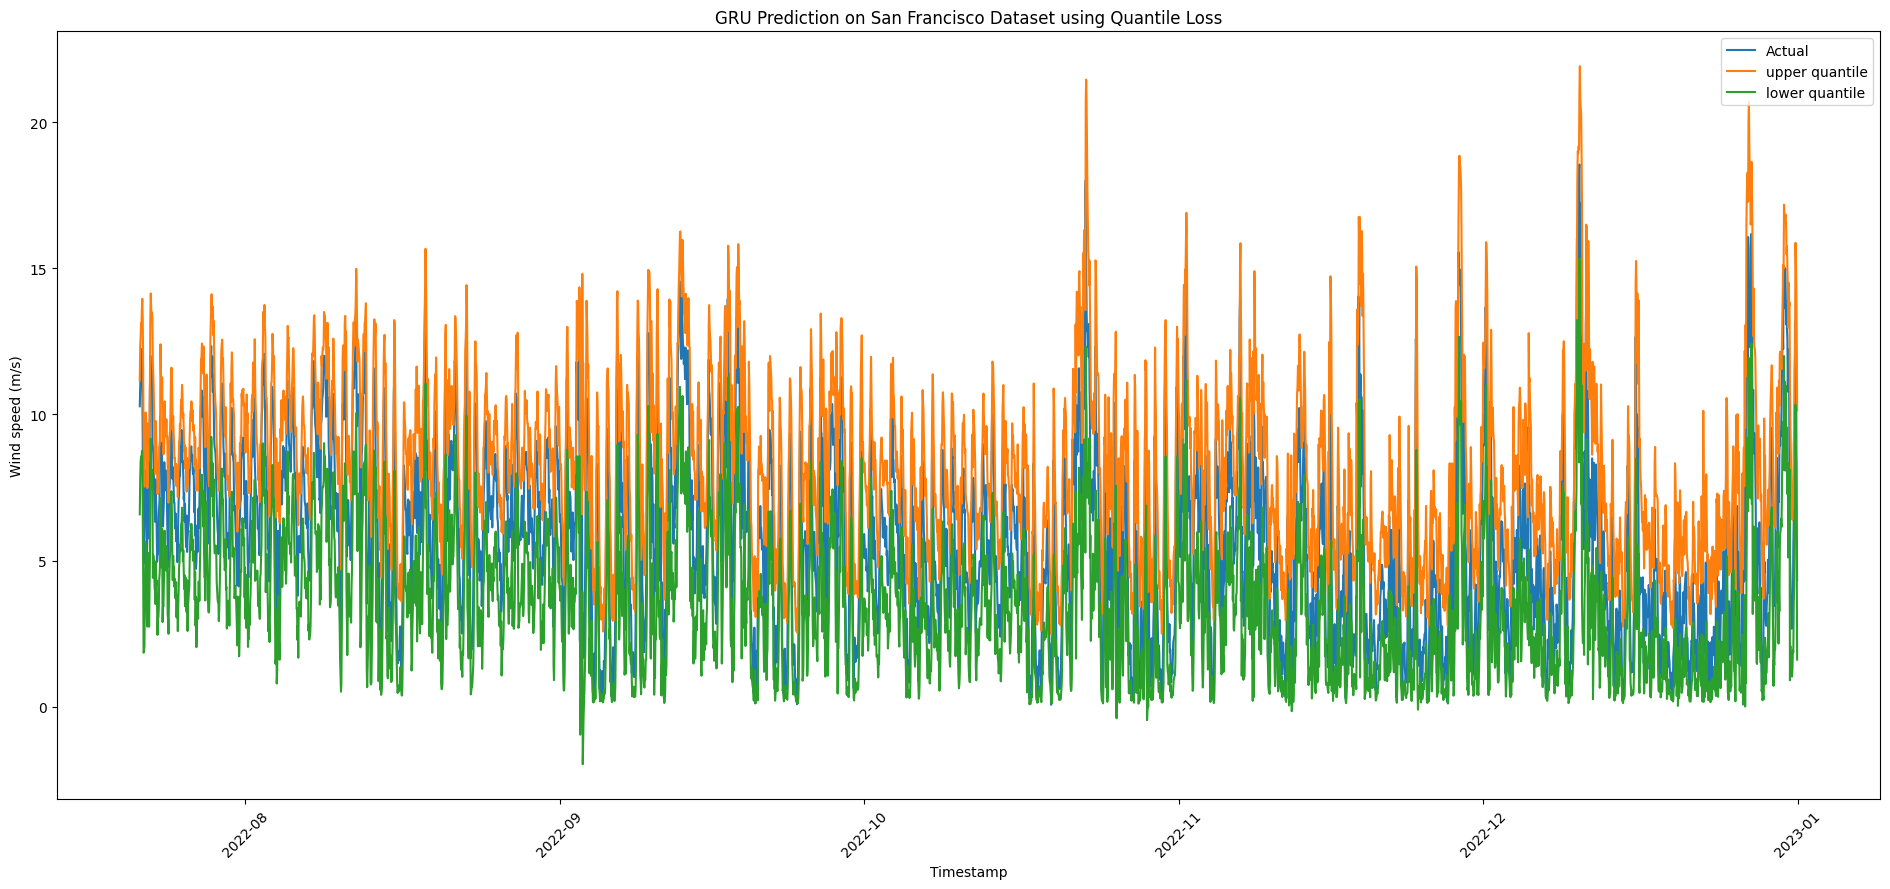

In [ ]:
actual=test_y_
# actual = np.squeeze(actual)
pred1=y_u_pred
pred2=y_l_pred
numEx = test_data.index
numEx = numEx[24:]
plt.figure(figsize=(19, 9))
plt.plot(numEx,actual,label='Actual')
plt.plot(numEx,pred1,label='upper quantile')
plt.plot(numEx,pred2,label='lower quantile')
plt.legend(loc='upper right')
plt.title('GRU Prediction on San Francisco Dataset using Quantile Loss')
plt.xlabel('Timestamp')
plt.ylabel('Wind speed (m/s)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('S_lstm_tube')
plt.show()

###### Quantile TCN

In [192]:
tf.keras.utils.set_random_seed(48)
tf.config.experimental.enable_op_determinism()
layers = [64,64]
dropout = 0
kernel = 3
quantile1 = create_tcn((input_window_size,1), layers, kernel, dropout)
quantile2 = create_tcn((input_window_size,1), layers, kernel, dropout)

In [193]:
tf.keras.utils.set_random_seed(48)
tf.config.experimental.enable_op_determinism()
q1=0.015
q2=0.965
quantile1.compile(loss=quantile_loss(q1),optimizer=Adam(learning_rate=0.001))
quantile2.compile(loss=quantile_loss(q2),optimizer=Adam(learning_rate=0.001))

In [194]:
tf.keras.utils.set_random_seed(48)
tf.config.experimental.enable_op_determinism()
epc = 300
stop_patience = 10
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=stop_patience, mode='min')
start_time = datetime.datetime.now()
history = quantile1.fit(train_x, train_y, epochs=epc, verbose=1, batch_size=128,  validation_data=(val_x, val_y), callbacks=[early_stopping])
end_time = datetime.datetime.now()
total_time = end_time - start_time
total_time1 = round(total_time.total_seconds(),2)
print('seconds taken:', total_time1,
	'\nstart_time:', start_time.strftime('%H:%M:%S'),
	'end_time:', end_time.strftime('%H:%M:%S'))

Epoch 1/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - loss: 0.0035 - val_loss: 0.0029
Epoch 2/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0026 - val_loss: 0.0028
Epoch 3/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0025 - val_loss: 0.0027
Epoch 4/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0024 - val_loss: 0.0027
Epoch 5/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0024 - val_loss: 0.0028
Epoch 6/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0024 - val_loss: 0.0029
Epoch 7/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0024 - val_loss: 0.0028
Epoch 8/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0024 - val_loss: 0.0029
Epoch 9/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0024 - val_loss: 0.0030
Epoch 10/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0023 - val_loss: 0.0028
Epoch 11/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0023 - val_loss: 0.0028
Epoch 12/300
144/144 ━━━━━━━━━

In [195]:
tf.keras.utils.set_random_seed(48)
tf.config.experimental.enable_op_determinism()
epc = 300
stop_patience = 10
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=stop_patience, mode='min')
start_time = datetime.datetime.now()
history = quantile2.fit(train_x, train_y, epochs=epc, verbose=1, batch_size=128,  validation_data=(val_x, val_y), callbacks=[early_stopping])
end_time = datetime.datetime.now()
total_time = end_time - start_time
total_time2 = round(total_time.total_seconds(),2)
print('seconds taken:', total_time2,
	'\nstart_time:', start_time.strftime('%H:%M:%S'),
	'end_time:', end_time.strftime('%H:%M:%S'))

Epoch 1/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0219 - val_loss: 0.0067
Epoch 2/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0059 - val_loss: 0.0057
Epoch 3/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0055 - val_loss: 0.0059
Epoch 4/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0053 - val_loss: 0.0056
Epoch 5/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0052 - val_loss: 0.0055
Epoch 6/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0052 - val_loss: 0.0054
Epoch 7/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0052 - val_loss: 0.0055
Epoch 8/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0051 - val_loss: 0.0054
Epoch 9/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0051 - val_loss: 0.0053
Epoch 10/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0051 - val_loss: 0.0053
Epoch 11/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0050 - val_loss: 0.0053
Epoch 12/300
144/144 ━━━━━━━━━

In [196]:
y_l_pred = quantile1.predict(test_x, verbose=0)
y_u_pred = quantile2.predict(test_x, verbose=0)
test_y_ = scaler_y.inverse_transform(test_y.reshape(-1,1))
# test_y_ = np.squeeze(test_y_[:,0])
y_l_pred = scaler_y.inverse_transform(y_l_pred)
y_u_pred = scaler_y.inverse_transform(y_u_pred)
K_u = y_u_pred > test_y_
K_l = y_l_pred < test_y_
PICP = np.mean(K_u * K_l)
MPIW = np.round(np.mean(y_u_pred - y_l_pred),3)
print('PICP:', PICP)
print('MPIW:', MPIW)

PICP: 0.9459459459459459
MPIW: 4.857


In [197]:
save_to_csv("quantile_"+savefilename, dataset, "Quantile_TCN", PICP, MPIW, total_time1 + total_time2, stop_patience, input_window_size, q1, q2, layers, dropout, kernel)

Data appended successfully to quantile_san_francisco.csv


In [198]:
quantile1.save('S_tcn_q1.keras')
quantile2.save('S_tcn_q2.keras')

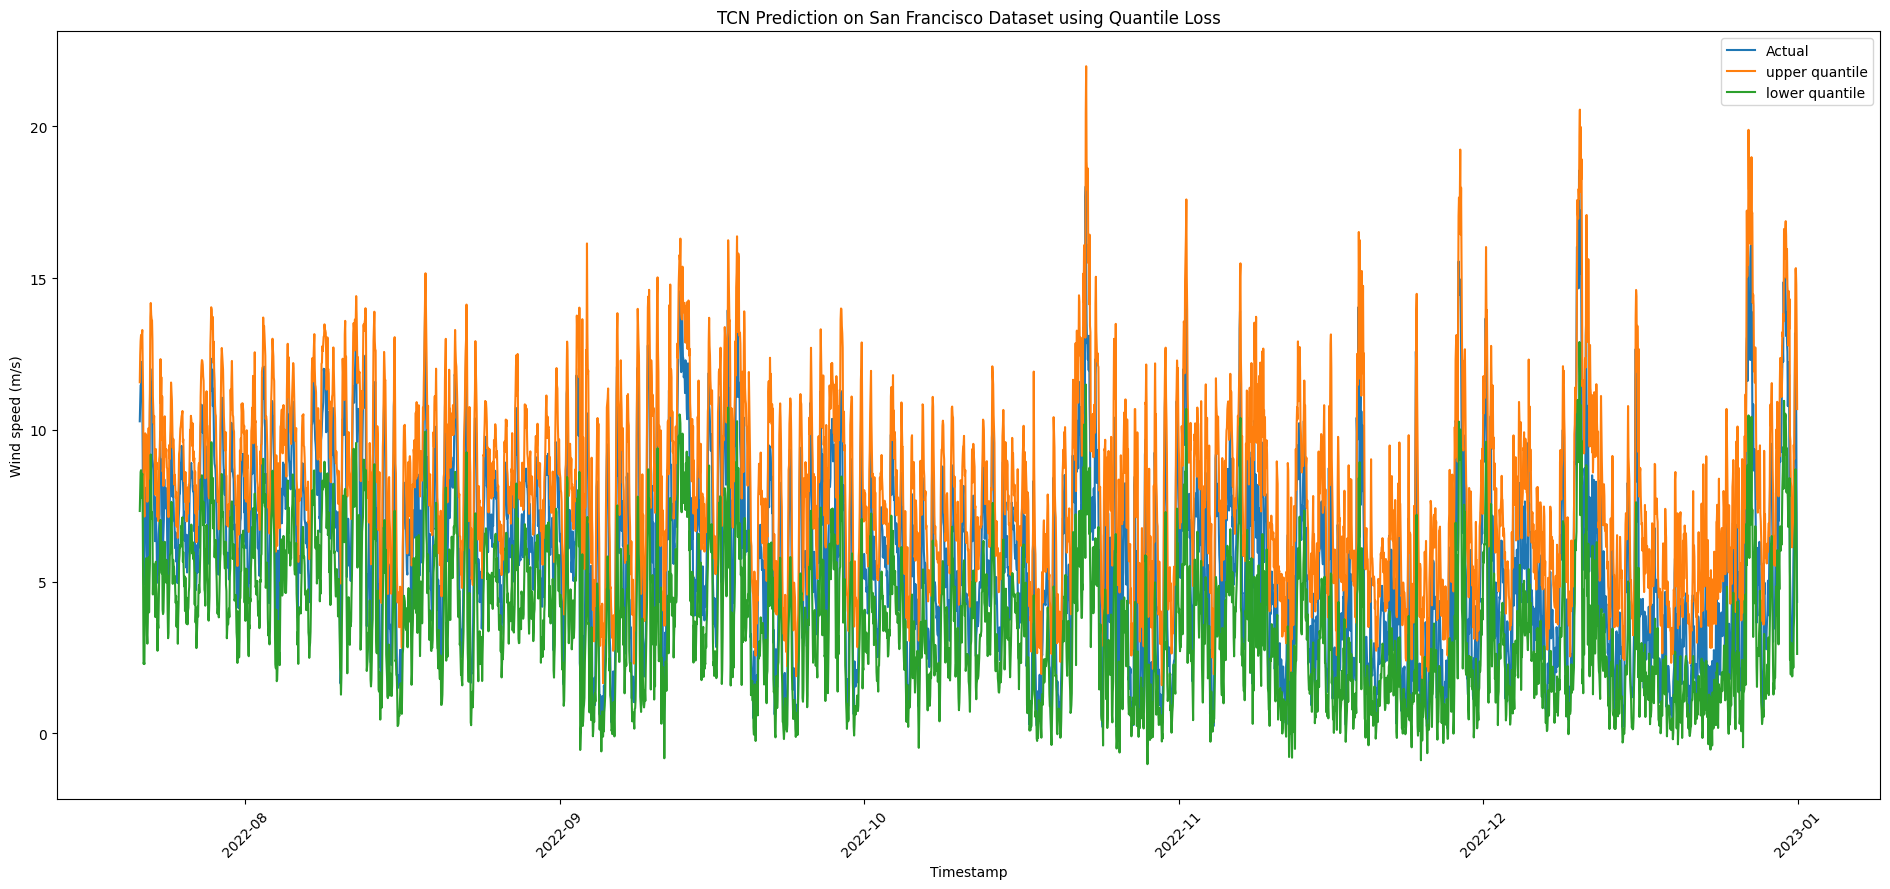

In [ ]:
actual=test_y_
# actual = np.squeeze(actual)
pred1=y_u_pred[:,:1]
pred2=y_l_pred[:,:1]
numEx = test_data.index
numEx = numEx[24:]
plt.figure(figsize=(19, 9))
plt.plot(numEx,actual,label='Actual')
plt.plot(numEx,pred1,label='upper quantile')
plt.plot(numEx,pred2,label='lower quantile')
plt.legend(loc='upper right')
plt.title('TCN Prediction on San Francisco Dataset using Quantile Loss')
plt.xlabel('Timestamp')
plt.ylabel('Wind speed (m/s)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('S_lstm_tube')
plt.show()